# Using MLRUN with MpiJobs (Horovod)

In [1]:
# nuclio: ignore
import nuclio

In [2]:
%nuclio config spec.build.baseImage = "python:3.6-jessie"

%nuclio: setting spec.build.baseImage to 'python:3.6-jessie'


## Helper functions for downloading and labeling images

In [3]:
import os
import zipfile
import json
from tempfile import mktemp
import pandas as pd


def open_archive(context, 
                 target_dir='content',
                 archive_url=''):
    """Open a file/object archive into a target directory"""
        
    # Define locations
    os.makedirs(target_dir, exist_ok=True)
    context.logger.info('Verified directories')
    
    # Extract dataset from zip
    context.logger.info('Extracting zip')
    zip_ref = zipfile.ZipFile(archive_url, 'r')
    zip_ref.extractall(target_dir)
    zip_ref.close()
    
    context.logger.info(f'extracted archive to {target_dir}')
    context.log_artifact('content', target_path=target_dir)

    
from mlrun.artifacts import TableArtifact

def categories_map_builder(context,
                           source_dir,
                           df_filename='file_categories_df.csv',
                           map_filename='categories_map.json'):
    """Read labeled images from a directory and create category map + df
    
    filename format: <category>.NN.jpg"""
    
    # create filenames list (jpg only)
    filenames = [file for file in os.listdir(source_dir) if file.endswith('.jpg')]
    categories = []
        
    # Create a pandas DataFrame for the full sample
    for filename in filenames:
        category = filename.split('.')[0]
        categories.append(category)

    df = pd.DataFrame({
        'filename': filenames,
        'category': categories
    })
    df['category'] = df['category'].astype('str')
    
    categories = df.category.unique()
    categories = {category: i for i, category in enumerate(categories)}
    with open(os.path.join(context.out_path, map_filename), 'w') as f:
        f.write(json.dumps(categories))
        
    context.logger.info(categories)
    context.log_artifact('categories_map', src_path=map_filename)
    context.log_artifact(TableArtifact('file_categories', df=df, src_path=df_filename))

In [4]:
# nuclio: end-code

# Complete Data-Science Pipeline with MLRun

- Get data
- Create categories map
- Train horovod model on the cluster
- Deploy model

In [5]:
from mlrun import new_function, code_to_function, get_run_db, mount_v3io, NewTask, mlconf, new_model_server
# for local DB path use 'User/mlrun' instead 
mlconf.dbpath = 'http://mlrun-db:8080'

In [6]:
base_dir = '/User/mlrun/examples'
images_path = os.path.join(base_dir, 'images')

### Step 1: Download and extract image archive

In [7]:
# download images from s3 using the local `open_archive` function
open_archive_task = NewTask('download', handler=open_archive, 
               params={'target_dir': images_path},
               inputs={'archive_url': 'http://iguazio-sample-data.s3.amazonaws.com/catsndogs.zip'})
open_archive_fn = new_function().run(open_archive_task)

[mlrun] 2019-11-01 01:35:13,740 starting run download uid=63c1c8b8899a445caa8f83806f8fcb82  -> http://mlrun-db:8080
[mlrun] 2019-11-01 01:35:13,860 downloading http://iguazio-sample-data.s3.amazonaws.com/catsndogs.zip to local tmp
[mlrun] 2019-11-01 01:35:15,519 Verified directories
[mlrun] 2019-11-01 01:35:15,520 Extracting zip
[mlrun] 2019-11-01 01:35:35,576 extracted archive to /User/mlrun/examples/images


uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...8fcb82,0,Nov 01 01:35:13,completed,download,kind=handlerowner=iguaziohost=jupyter-dulwoc9x63-ixir3-68dccc6b7-4psd5,archive_url,target_dir=/User/mlrun/examples/images,,content


type result.show() to see detailed results/progress or use CLI:
!mlrun get run --uid 63c1c8b8899a445caa8f83806f8fcb82 
[mlrun] 2019-11-01 01:35:35,632 run executed, status=completed


### Step 2: Tag Images with Categories (cat & dog)

In [8]:
# Create categories map
label_task = NewTask('label', handler=categories_map_builder, out_path=images_path,
                              params={'source_dir': os.path.join(images_path, 'cats_n_dogs')})
labeler_function = new_function().run(label_task)

[mlrun] 2019-11-01 01:35:35,638 starting run label uid=a4adcd46b1eb480a813a35a45fbfc63f  -> http://mlrun-db:8080
[mlrun] 2019-11-01 01:35:35,722 {'cat': 0, 'dog': 1}


uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...bfc63f,0,Nov 01 01:35:35,completed,label,kind=handlerowner=iguaziohost=jupyter-dulwoc9x63-ixir3-68dccc6b7-4psd5,,source_dir=/User/mlrun/examples/images/cats_n_dogs,,categories_mapfile_categories


type result.show() to see detailed results/progress or use CLI:
!mlrun get run --uid a4adcd46b1eb480a813a35a45fbfc63f 
[mlrun] 2019-11-01 01:35:35,811 run executed, status=completed


### Step 3: Distributed Training with TensorFlow, Keras and Horovod

In [19]:
code_dir = '/User/mlrun'
HOROVOD_FILE = os.path.join(code_dir, 'horovod-training.py')

params = {
    'checkpoints_dir' : os.path.join(base_dir, 'checkpoints'),
    'model_path' : os.path.join(base_dir, 'models/cats_n_dogs.hd5'),
    'epochs' : 1,
    'batch_size' : 64,
    'image_width': 128,
    'image_height': 128,
    'image_channels': 3
}

inputs = {
    'data_path' : os.path.join(images_path, 'cats_n_dogs'),    
    'categories_map': labeler_function.outputs['categories_map'],
    'file_categories': labeler_function.outputs['file_categories']
}

image = 'mlrun/mpijob:latest'
trainer = new_function(name='horovod-trainer',
                       command='mpijob://{}'.format(HOROVOD_FILE), 
                       image=image,
                       interactive=True)
trainer.apply(mount_v3io())
trainer.spec.image_pull_policy = 'Always'
trainer.spec.replicas = 4
# trainer.gpus(1)
mprun = trainer.run(name='train', params=params, out_path='/User/mlrun', inputs=inputs)

[mlrun] 2019-11-01 14:54:18,193 starting run train uid=d2f7c469a1054bf380f69a62c34bb66c  -> http://mlrun-db:8080
[mlrun] 2019-11-01 14:54:18,233 using in-cluster config.
[mlrun] 2019-11-01 14:54:18,245 MpiJob train-aa7fad2c created
[mlrun] 2019-11-01 14:54:25,270 MpiJob train-aa7fad2c state=Active
...
+ POD_NAME=train-aa7fad2c-worker-1
+ shift
+ /opt/kube/kubectl exec train-aa7fad2c-worker-1 -- /bin/sh -c     PATH=/usr/local/bin:$PATH ; export PATH ; LD_LIBRARY_PATH=/usr/local/lib:$LD_LIBRARY_PATH ; export LD_LIBRARY_PATH ; DYLD_LIBRARY_PATH=/usr/local/lib:$DYLD_LIBRARY_PATH ; export DYLD_LIBRARY_PATH ;   /usr/local/bin/orted -mca ess "env" -mca ess_base_jobid "4231593984" -mca ess_base_vpid 2 -mca ess_base_num_procs "5" -mca orte_node_regex "train-aa[1:7]fad2c-launcher-c6fr6,train-aa[1:7]fad2c-worker-0,train-aa[1:7]fad2c-worker-1,train-aa[1:7]fad2c-worker-2,train-aa[1:7]fad2c-worker-3@0(5)" -mca orte_hnp_uri "4231593984.0;tcp://10.233.81.136:55234" -mca plm "rsh" --tree-spawn -mca ort

uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...4bb66c,0,Nov 01 14:54:33,completed,train,host=train-aa7fad2c-worker-0kind=mpijobmlrun/job=train-aa7fad2cowner=iguazio,categories_mapdata_pathfile_categories,batch_size=64checkpoints_dir=/User/mlrun/examples/checkpointsepochs=1image_channels=3image_height=128image_width=128model_path=/User/mlrun/examples/models/cats_n_dogs.hd5,accuracy=0.6348437070846558loss=0.8034598758816719,modelsummary.html


type result.show() to see detailed results/progress or use CLI:
!mlrun get run --uid d2f7c469a1054bf380f69a62c34bb66c 
[mlrun] 2019-11-01 15:02:32,731 run executed, status=completed


In [13]:
fn.delete_job('train-1bd63853')

[mlrun] 2019-10-28 21:36:55,558 del status: Success


### Step 4: Deploy Model Serving Function
The following code will use a Nuclio serving function from GitHub (in a Notebook format) and will deploy it with proper arguments 

In [10]:
model_name = 'cat_vs_dog_v1'

In [23]:
# convert the notebook code to deployable function, configure it
from mlrun import code_to_function
inference_function = code_to_function(name='tf-image-serving', 
                                      filename='https://raw.githubusercontent.com/mlrun/demos/master/image_classification/nuclio-serving-tf-images.ipynb',
                                      runtime='nuclio')

# set the API/trigger, attach the home dir to the function
inference_function.with_http(workers=2).add_volume('User','~/')

# set the model file path SERVING_MODEL_<name> = <model file path>
inference_function.set_env(f'SERVING_MODEL_{model_name}', params['model_path'])
addr = inference_function.deploy(project='nuclio-serving')

[nuclio.deploy] 2019-11-02 01:09:47,962 (info) Building processor image


INFO:nuclio.deploy:(info) Building processor image


[nuclio.deploy] 2019-11-02 01:09:53,016 (info) Build complete


INFO:nuclio.deploy:(info) Build complete


[nuclio.deploy] 2019-11-02 01:09:57,049 (info) Function deploy complete


INFO:nuclio.deploy:(info) Function deploy complete


[nuclio.deploy] 2019-11-02 01:09:57,055 done updating tf-image-serving, function address: 13.58.34.174:32204


INFO:nuclio.deploy:done updating tf-image-serving, function address: 13.58.34.174:32204


### Test The Serving Function (with Image URL)

[0.11255746334791183]


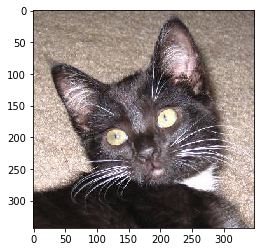

In [24]:
cat_image_url = 'https://s3.amazonaws.com/iguazio-sample-data/images/catanddog/cat.102.jpg'
response = requests.get(cat_image_url)
img = Image.open(BytesIO(response.content))
plt.imshow(img)

headers = {'Content-type': 'text/plain'}
response = requests.post(url=addr + '/predict/cat_dog_v1', data=cat_image_url, headers=headers)
print(response.content.decode('utf-8'))

### Test The Serving Function (with Jpeg Image)

[1.0]


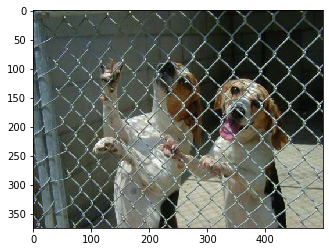

In [25]:
dog_image_url = 'https://s3.amazonaws.com/iguazio-sample-data/images/catanddog/dog.331.jpg'
response = requests.get(dog_image_url)
img = Image.open(BytesIO(response.content))
plt.imshow(img)

headers = {'Content-type': 'image/jpeg'}
response = requests.post(url=addr + '/predict/cat_dog_v1', data=response.content, headers=headers)
print(response.content.decode('utf-8'))

### Alternative: Deploy Function From Pre-built (container) Image

In [11]:
# Declare model server
srvfn = new_model_server('tf-image-server', 
                         models={model_name: params['model_path']}, 
                         model_class='TFModel',
                         image='zilbermanor/nuclio-serving-tf-image-server:latest')
srvfn.with_v3io('User','~/')  # Add v3io mount
srvfn.spec.env['IMAGE_WIDTH'] = 128
srvfn.spec.env['IMAGE_HEIGHT'] = 128

# Deploy
addr = srvfn.deploy(project='nuclio-serving')

[mlrun] 2019-11-01 01:38:51,594 deploy started
[nuclio.deploy] 2019-11-01 01:38:57,697 (info) Function deploy complete
[nuclio.deploy] 2019-11-01 01:38:57,702 done updating tf-image-server, function address: 13.58.34.174:31725
